# disable outliers

Given a set of 3d points and a set of joints:

$$
X_j = \big\{ x_a^j \big\}_a^{n_j}, \ \ x_a^j \in \mathbb{R}^3, \ \ 
j \in \mathcal{J}
$$
with
$$
\mathcal{J} =  \{1, .., J\}
$$

as well as a set of limbs:

$$
L = \big\{ (j,\hat{j})_l \big\}_l, \ \ \ j,\hat{j} \in \mathcal{J}
$$

define edges between joints of the same class as follows:

$$
E_j = \big\{ 
(x_a^j, x_b^j) : a \neq b \wedge 
\vert\vert x_a^j - x_b^j \vert\vert_2^2 < \delta
\big\}
$$

where $\delta$ is a distance threshold (in $mm$) after which no connection is considered anymore.
Furthermore, define edges over limbs as follows:

$$
E_l = \big\{ 
(x_a^j, x_b^{\hat{j}}) : j \neq \hat{j} \wedge
(j, \hat{j}) \in L \wedge
\epsilon_{min}^l < \vert\vert x_a^j - x_b^{\hat{j}} \vert\vert_2^2
< \epsilon_{max}^l
\big\}$$

where $\epsilon_{min}^l, \epsilon_{max}^l$ represent the minimal/maximal length of a given limb $l$ (in $mm$).

Our graph $G=(D, E)$ is defined as follows:
$$
D = \bigcup_{j \in \mathcal{J}} X_j
$$
$$
E = E_j \ \cup \ E_l
$$

Now define 
* $\nu \in \{0, 1\}^{\vert D \vert}$, a binary variable that defines if a node is being removed or not
* $\lambda \in \{0, 1\}^{\vert E_l \vert}$, a binary variable that defines if a limb is removed or not
* $\iota \in \{0, 1\}^{\vert E_j \vert}$, a binary variable that defines if two nodes of the same joint type belong to the same candidate or not

A partitioning is obtained by maximizing the cost function:

$$
\underset{\nu, \lambda, \iota}{\mathrm{argmax}} 
\left \langle \nu, \phi \right \rangle + 
\left \langle \lambda, \Psi_{\lambda} \right \rangle + 
\left \langle \iota, \Psi_{\iota} \right \rangle
$$

with

$$
\left \langle \nu, \phi \right \rangle  = \sum_{d\in D} v_d \log \frac{p_d}{1-p_d}
$$

where $$p_d = \big(\frac{w_1^d + w_2^d}{2} + 
\frac{\exp[{-d_1}] + \exp[-d_2]}{2} \big) / 2 \\
=\frac{w_1^d + w_2^d + \exp[{-d_1}] + \exp[-d_2]}{4}
$$ and where $w_1^d, w_2^d \in (0, 1)$ are the belief that the detection is from the detected joint class. This values are given by the neural network and a single 3d point has two of them as it is triangulated from two views. $d_1$ and $d_2$ represent the distance of 
each 2d point that makes up the 3d point to the respective epipolar line. If the points fit prefectly then $d_1 =d_2 = 0$.

The limb costs $\left \langle \lambda, \psi_{\lambda} \right \rangle$ are defined as follows:

$$
\left \langle \lambda, \Psi_{\lambda} \right \rangle = 
\sum_{(x_a^j, x_b^{\hat{j}}) \in E_l} \lambda(x_a^j, x_b^{\hat{j}}) \psi_{\lambda}(x_a^j, x_b^{\hat{j}})
$$

with 
$$
\psi_{\lambda}(x_a^j, x_b^{\hat{j}}) = \log \biggr( 
\frac{p_\lambda(a, b)+1}{2 \big( \frac{1}{2} (-p_\lambda(a, b)-1) + 1\big)}
\biggr)
$$

where $p_\lambda(a, b) \in (-1, 1)$ defines the cost over the part affinity field of the given limb.

Last but not least we take a look at the formulation of the joint costs $\left \langle \iota, \Psi_{\iota} \right \rangle$ which simply linearly decreases with the distance between two points.

$$
\left \langle \iota, \Psi_{\iota} \right \rangle = \sum_{(x_a^j, x_b^j) \in E_{j}} \iota(x_a^j, x_b^j) \cdot \big( -\vert\vert x_a^j - x_b^j \vert\vert_2^2 \big)
$$

Several conditions have to be met for the optimization to yield valid results. First, it needs to be enured that only edges are considered when both nodes are valid:

$$
\lambda(a,b) \leq \nu(a) \wedge \lambda(a,b) \leq \nu(b) \ \ \ \ \forall (a,b) \in E_l
$$

$$
\iota(a,b) \leq \nu(a) \wedge \iota(a,b) \leq \nu(b) \ \ \ \ \forall (a,b) \in E_j
$$

Second, transitivity has to be enures:

$$
\lambda(a,c) + \lambda(b,c) -1 \leq \iota(a,b)
$$

$$
\lambda(a,c) + \iota(a,b) -1 \leq \lambda(b,c)
$$

$$
\iota(a,b) + \iota(a,c) -1 \leq \iota(b,c)
$$

In [1]:
import numpy as np
big_span = lambda x: np.log((x+1) / (2 * (0.5 * (-x -1)+1)))

small_span = lambda x: np.log(x/(1-x))

X = np.linspace(-0.99, 0.99, 100)
Y = [big_span(x) for x in X]

print('bigspan:', (np.min(Y), np.max(Y)))

X = np.linspace(0.001, 0.99, 100)
Y = [small_span(x) for x in X]

print('smallspan:', (np.min(Y), np.max(Y)))

bigspan: (-5.293304824724491, 5.293304824724491)
smallspan: (-6.906754778648554, 4.595119850134589)


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from graphviz import Graph
import numpy as np
from ortools.linear_solver import pywraplp as mip
import sys
sys.path.insert(0,'../')
from mvpose.candidates.transitivity import TransitivityLookup


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SOLVE ALL
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def solve_all(Limb_weights, Limbs, Unaries, Joints):
    
    get = lambda M, i, j: M[(min(i,j), max(i,j))]
    shape = lambda M: (np.max(np.array(list(M.keys()))[:,0]) + 1, \
                    np.max(np.array(list(M.keys()))[:,1]) + 1)

    solver = mip.Solver('m', mip.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    D = []
    E_l = []
    E_j = []

    # --------

    Nu = {}
    Lambda = {}  # jid1 jid2 a b
    Iota = {}  # jid a b
    Get_Iota = lambda jid, a, b: Iota[jid, min(a, b), max(a, b)]
    Get_Lambda = lambda jid1, jid2, a, b: Lambda[jid1, jid2, a, b] \
        if jid1 < jid2 else Lambda[jid2, jid1, b, a]

    Sum = []

    # ~~~ handle NU ~~~
    for jid, U in enumerate(Unaries):
        for idx, u in enumerate(U):
            Nu[jid, idx] = solver.BoolVar('nu[%i,%i]' % (jid, idx))
            D.append((jid, idx))

        s = solver.Sum(
            Nu[jid, idx] * small_span(u) for idx, u in enumerate(U)
        )
        Sum.append(s)


    # ~~~ handle intra-class ~~~
    for jid, J in enumerate(Joints):
        for a, b in J.keys():
            Iota[jid, a, b] = solver.BoolVar('j[%i,%i,%i]' % (jid, a, b))
            E_j.append((jid, a, b))

        s = solver.Sum(
            Iota[jid, a, b] * J[a,b] for a,b in J.keys()
        )
        Sum.append(s)

    # ~~~ handle inter-class ~~~
    inter_class_handled = set()
    for lid, (W, (jid1, jid2)) in enumerate(zip(Limb_weights, Limbs)):

        jids_flipped = False
        if jid1 > jid2:
            jids_flipped = True
            temp = jid2; jid2 = jid1; jid1 = temp

        for a,b in W.keys():
            if jids_flipped:
                temp = a; a = b; b = temp

            if (jid1, jid2, a, b) in inter_class_handled:
                continue
            inter_class_handled.add((jid1, jid2, a, b))

            Lambda[jid1, jid2, a, b] = solver.BoolVar(
                'l[%i,%i,%i,%i]' % (jid1, jid2, a, b))
            E_l.append((jid1, jid2, a, b))

        if jids_flipped:
            s = solver.Sum(
                Lambda[jid1, jid2, b, a] * big_span(W[a,b]) for a,b in W.keys()
            )
        else:
            s = solver.Sum(
                Lambda[jid1, jid2, a, b] * big_span(W[a,b]) for a,b in W.keys()
            )

        Sum.append(s)

    # ~~~ handle conditions ~~~
    for jid1, jid2, a, b in E_l:
        solver.Add(
            Lambda[jid1, jid2, a, b] * 2<= Nu[jid1, a] + Nu[jid2, b]
        )

    for jid, a, b in E_j:
        solver.Add(
            Iota[jid, a, b] * 2 <= Nu[jid, a] + Nu[jid, b]
        )

    transitivity_lookup = TransitivityLookup(D, E_l, E_j)

    Intra = []
    Inter = []
    Intra_choice = []
    Inter_choice = []
    

    for q in D:
        intra, intra_choice, inter, inter_choice =\
            transitivity_lookup.query_with_choice(*q)
        Intra += intra
        Inter += inter
        Intra_choice += intra_choice
        Inter_choice += inter_choice

    Inter = set(Inter)
    Intra = set(Intra)
    print("Edges (inter):", len(Inter))
    print("Edges (intra):", len(Intra))
    print("Edges (inter/choices):", len(Inter_choice))
    print("Edges (intra/choices):", len(Intra_choice))
    
    QQ = [str(tr.lookup[jid1, a]) + '-' + str(tr.lookup[jid2, b]) + '-' + str(tr.lookup[jid3, c]) \
        for jid1, a, jid2, b, jid3, c in Inter_choice]
    
    # ~~~ sanity check ~~~
    lkp = set()
    for q in Intra:
        assert q not in lkp
        lkp.add(q)

    lkp = set()
    for q in Inter:
        assert q not in lkp
        lkp.add(q)
    # ~~~ sanity check OVER ~~~

    for jid, a, b, c in Intra:
        solver.Add(
            Get_Iota(jid, a,b) + Get_Iota(jid, a,c) - 1 <= Get_Iota(jid, b, c))

    for jid1, a, b, jid3, c in Inter:
        solver.Add(
            Get_Lambda(jid1, jid3, a, c) + Get_Iota(jid1, a, b) - 1 <= Get_Lambda(jid1, jid3, b, c))
        solver.Add(
            Get_Lambda(jid1, jid3, b, c) + Get_Iota(jid1, a, b) - 1 <= Get_Lambda(jid1, jid3, a, c))
        solver.Add(
            Get_Lambda(jid1, jid3, a, c) + Get_Lambda(jid1, jid3, b, c) - 1 <= Get_Iota(jid1, a, b))
    
    
    for jid, a, b, c in Intra_choice:  # either take { ab OR ac }
        solver.Add(
            Get_Iota(jid, a, b) + Get_Iota(jid, b, c) <= 1
        )
    
    for jid1, a, jid2, b, jid3, c in Inter_choice:  # { ab OR ac }
        if jid1 == jid2:
            assert jid3 != jid1
            # if  [a]---[b]
            #     |
            #    (c)
            solver.Add(
                Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
            )
        elif jid2 == jid3:
            # if  [a]
            #     |   \
            #    (b)   (c)
            solver.Add(
                Get_Lambda(jid1, jid2, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
            )
        elif jid1 == jid3:
            # if  [a]---[c]
            #     |
            #    (b)
            solver.Add(
                Get_Lambda(jid1, jid2, a, b) + Get_Iota(jid1, a, c) <= 1
            )
        
        

    # ~~~ execute optimization ~~~
    solver.Maximize(sum(Sum))
    result = solver.Solve()
    print("Time = ", solver.WallTime(), " ms")
    print('result', result)


    # ~~~ create clusters ~~~

    print('\nNU:')
    for k, v in Nu.items():
        print(str(k) + '->', v.solution_value())


    print('\nITOA:')    
    for k, v in Iota.items():
        print(str(k) + '->', v.solution_value())

    print('\nLAMBDA:')    
    for k, v in Lambda.items():
        print(str(k) + '->', v.solution_value())
        
#     plt.subplot(111)
#     transitivity_lookup.plot()
    return transitivity_lookup

        
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# 3 node levels: A, B, C
# intra-class weights
A = {
    (0, 1): 2,
    (0, 2): -4,
    (1, 2): -5
}

B = {
    (0, 1): -1,
    (0, 2): -6,
    (1, 2): -7
}

C = {
    (0, 1): -1
}

# inter-class weights
W1 = {
    (0, 0): 0.99,
    (0, 1): -0.3,
    (0, 2): -0.1,
    (1, 0): 0.6,
    (1, 1): 0.1,
    (1,2): -0.8,
    (2,0): -0.1,
    (2,1): 0.1,
    (2, 2): -0.1
}

W2 = {
    (0, 0): 0.3,
    (0, 1): 0.1,
    (1, 0): -0.01,
    (1, 1): 0.8,
    (2, 0): -0.4,
    (2, 1): 0.1
}

W3 = {
    (0, 0):  0.8,
    (0, 1): -0.1,
    (0, 2): 0,
    (1, 0): -0.9,
    (1, 1): 0.4,
    (1, 2): 0
}

U_a = [0.6, 0.4, 0.5]
U_b = [0.6, 0.6, 0.3]
U_c = [0.9, 0.3]

Limb_weights = [W1, W2, W3]
Limbs = [(0, 1), (1, 2), (2, 0)]
Unaries = [U_a, U_b, U_c]
Joints = [A, B, C]

tr = solve_all(Limb_weights, Limbs, Unaries, Joints)

Edges (inter): 36
Edges (intra): 6
Edges (inter/choices): 0
Edges (intra/choices): 0
Time =  13  ms
result 0

NU:
(0, 0)-> 1.0
(0, 1)-> 1.0
(0, 2)-> 1.0
(1, 0)-> 1.0
(1, 1)-> 1.0
(1, 2)-> 0.0
(2, 0)-> 1.0
(2, 1)-> 1.0

ITOA:
(0, 0, 1)-> 1.0
(0, 0, 2)-> 0.0
(0, 1, 2)-> 0.0
(1, 0, 1)-> 0.0
(1, 0, 2)-> 0.0
(1, 1, 2)-> 0.0
(2, 0, 1)-> 0.0

LAMBDA:
(0, 1, 0, 0)-> 1.0
(0, 1, 0, 1)-> 0.0
(0, 1, 0, 2)-> 0.0
(0, 1, 1, 0)-> 1.0
(0, 1, 1, 1)-> 0.0
(0, 1, 1, 2)-> 0.0
(0, 1, 2, 0)-> 0.0
(0, 1, 2, 1)-> 1.0
(0, 1, 2, 2)-> 0.0
(1, 2, 0, 0)-> 1.0
(1, 2, 0, 1)-> 0.0
(1, 2, 1, 0)-> 0.0
(1, 2, 1, 1)-> 1.0
(1, 2, 2, 0)-> 0.0
(1, 2, 2, 1)-> 0.0
(0, 2, 0, 0)-> 1.0
(0, 2, 1, 0)-> 1.0
(0, 2, 2, 0)-> 0.0
(0, 2, 0, 1)-> 0.0
(0, 2, 1, 1)-> 0.0
(0, 2, 2, 1)-> 0.0


['4-5-8', '4-5-7', '4-6-8', '4-6-7', '7-8-4']


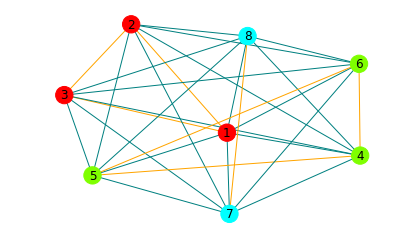

In [7]:
intra, intra_choice, inter, inter_choice = tr.query_with_choice(1, 0)

Intra = [str(tr.lookup[jid, a]) + '-' + str(tr.lookup[jid, b]) + '-' + str(tr.lookup[jid, c]) \
         for jid, a, b, c in intra]

Inter = [str(tr.lookup[jid1, a]) + '-' + str(tr.lookup[jid1, b]) + '-' + str(tr.lookup[jid3, c]) \
        for jid1, a, b, jid3, c in inter]

print(Inter)

plt.subplot(111)
tr.plot()

## Real-World-Problem: limb-edges are mostly positive values

Edges (inter): 8
Edges (intra): 0
Edges (inter/choices): 19
Edges (intra/choices): 0
Time =  7  ms
result 0

NU:
(0, 0)-> 1.0
(0, 1)-> 1.0
(0, 2)-> 1.0
(1, 0)-> 1.0
(1, 1)-> 1.0
(1, 2)-> 1.0
(2, 0)-> 1.0
(2, 1)-> 1.0

ITOA:
(0, 0, 1)-> 1.0
(1, 0, 1)-> 1.0

LAMBDA:
(0, 1, 0, 0)-> 1.0
(0, 1, 0, 1)-> 1.0
(0, 1, 0, 2)-> 0.0
(0, 1, 1, 0)-> 1.0
(0, 1, 1, 1)-> 1.0
(0, 1, 1, 2)-> 0.0
(0, 1, 2, 0)-> 0.0
(0, 1, 2, 1)-> 0.0
(0, 1, 2, 2)-> 1.0
(1, 2, 0, 0)-> 1.0
(1, 2, 0, 1)-> 0.0
(1, 2, 1, 0)-> 1.0
(1, 2, 1, 1)-> 0.0
(1, 2, 2, 0)-> 0.0
(1, 2, 2, 1)-> 1.0


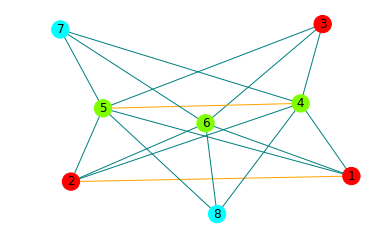

In [10]:
# 3 node levels: A, B, C
# intra-class weights
A = {
    (0, 1): 0,
}

B = {
    (0, 1): 0,
}

C = {
}

# inter-class weights
W1 = {
    (0, 0): 0.1,
    (0, 1): 0.1,
    (0, 2): 0.1,
    (1, 0): 0.1,
    (1, 1): 0.1,
    (1,2): 0.1,
    (2,0): 0.1,
    (2,1): 0.1,
    (2, 2): 0.1
}

W2 = {
    (0, 0): 0.1,
    (0, 1): 0.1,
    (1, 0): 0.1,
    (1, 1): 0.1,
    (2, 0): 0.1,
    (2, 1): 0.1
}


U_a = [0.99, 0.99, 0.99]
U_b = [0.99, 0.99, 0.99]
U_c = [0.99, 0.99]

Limb_weights = [W1, W2]
Limbs = [(0, 1), (1, 2)]
Unaries = [U_a, U_b, U_c]
Joints = [A, B, C]

tr = solve_all(Limb_weights, Limbs, Unaries, Joints)

intra, intra_choice, inter, inter_choice = tr.query_with_choice(1, 0)

plt.subplot(111)
tr.plot()